In [1]:
!pip install squarify
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import squarify 

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load dataset and parse to Dataframe
xlsx = pd.ExcelFile(r'C:\Users\Kayz\OneDrive - National Economics University\Python\Final Project RFM\dataset.xlsx')
ecommerce_retail = xlsx.parse('ecommerce retail')
segmentation = xlsx.parse('Segmentation')

In [3]:
#Detecting missing or error values
ecommerce_retail.isna().any()
# Data has missing or error values in Description and CustomerID but we just need to focus on CustomerID in this project

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [4]:
#Remove all missing values in CustomerID
ecommerce_retail = ecommerce_retail.dropna(subset = ['CustomerID'])

In [5]:
#Convert InvoiceDate and CustomerID to the potentially correct data type
ecommerce_retail['InvoiceDate'] = pd.to_datetime(ecommerce_retail['InvoiceDate'])
ecommerce_retail['CustomerID'] = ecommerce_retail['CustomerID'].astype(int)

In [6]:
#InvoiceNo start with 'C' is cancellation so we need to remove it
Final_data = ecommerce_retail[ecommerce_retail['Quantity'] >= 0]
Final_data['InvoiceNo'] = Final_data['InvoiceNo'].astype(int)
Final_data['Revenue'] = Final_data['Quantity'] * Final_data['UnitPrice']
Final_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [7]:
#Shorten Final_data to calculate RFM
Final_data_s = Final_data.groupby(['InvoiceNo', 'Country', 'CustomerID']).agg({'InvoiceDate': 'max',
                                                                              'Revenue': 'sum'}).reset_index()
Final_data_s

,InvoiceNo,Country,CustomerID,InvoiceDate,Revenue
0,536365,United Kingdom,17850,2010-12-01 08:26:00,139.12
1,536366,United Kingdom,17850,2010-12-01 08:28:00,22.20
2,536367,United Kingdom,13047,2010-12-01 08:34:00,278.73
3,536368,United Kingdom,13047,2010-12-01 08:34:00,70.05
4,536369,United Kingdom,13047,2010-12-01 08:35:00,17.85
...,...,...,...,...,...
18531,581583,United Kingdom,13777,2011-12-09 12:23:00,124.60
18532,581584,United Kingdom,13777,2011-12-09 12:25:00,140.64
18533,581585,United Kingdom,15804,2011-12-09 12:31:00,329.05
18534,581586,United Kingdom,13113,2011-12-09 12:49:00,339.20


In [8]:
# Set date to calculate and add 1 day to d (to calculate the date distance more exactly)
d = datetime(year=2011, month=12, day=31) + timedelta(days=1)

In [9]:
#Calculate Frequency, Monetary and Recency
df = Final_data_s[['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Revenue']]
df_customers = df.groupby('CustomerID').agg({'InvoiceDate': 'max', 'InvoiceNo': 'count', 'Revenue': 'sum'}).reset_index()
df_customers.columns = ['CustomerID', 'Max_date', 'Frequency', 'Monetary']
df_customers['Recency'] = (d - df_customers['Max_date']).dt.days
df_customers = df_customers.drop('Max_date', axis=1)
df_customers

,CustomerID,Frequency,Monetary,Recency
0,12346,1,77183.60,347
1,12347,7,4310.00,24
2,12348,4,1797.24,97
3,12349,1,1757.55,40
4,12350,1,334.40,332
...,...,...,...,...
4334,18280,1,180.60,299
4335,18281,1,80.82,202
4336,18282,2,178.05,29
4337,18283,16,2094.88,25


In [10]:
# (RFM)Divide results by levels 1,2,3,4,5
r_labels, f_labels, m_labels = range(5, 0, -1), range(1, 6), range(1, 6)

df_customers["Recency_score"] = pd.qcut(df_customers['Recency'], q=5,labels=r_labels)
df_customers["Frequency_score"] = pd.qcut(df_customers['Frequency'].rank(method='first'), q=5, labels=False) + 1
df_customers["Monetary_score"] = pd.qcut(df_customers["Monetary"],q=5, labels=m_labels)
df_customers

,CustomerID,Frequency,Monetary,Recency,Recency_score,Frequency_score,Monetary_score
0,12346,1,77183.60,347,1,1,5
1,12347,7,4310.00,24,5,5,5
2,12348,4,1797.24,97,2,4,4
3,12349,1,1757.55,40,4,1,4
4,12350,1,334.40,332,1,1,2
...,...,...,...,...,...,...,...
4334,18280,1,180.60,299,1,2,1
4335,18281,1,80.82,202,1,2,1
4336,18282,2,178.05,29,5,3,1
4337,18283,16,2094.88,25,5,5,5


In [11]:
# concate 3 score column to RFM_score
df_customers['RFM_Score'] = df_customers['Recency_score'].astype(str) + df_customers['Frequency_score'].astype(str) + df_customers['Monetary_score'].astype(str)
df_customers['RFM_Score'] = df_customers['RFM_Score'].astype(int)
df_customers

,CustomerID,Frequency,Monetary,Recency,Recency_score,Frequency_score,Monetary_score,RFM_Score
0,12346,1,77183.60,347,1,1,5,115
1,12347,7,4310.00,24,5,5,5,555
2,12348,4,1797.24,97,2,4,4,244
3,12349,1,1757.55,40,4,1,4,414
4,12350,1,334.40,332,1,1,2,112
...,...,...,...,...,...,...,...,...
4334,18280,1,180.60,299,1,2,1,121
4335,18281,1,80.82,202,1,2,1,121
4336,18282,2,178.05,29,5,3,1,531
4337,18283,16,2094.88,25,5,5,5,555


In [12]:
# Split the RFM_Score to more rows
segmentation['RFM Score'] = segmentation['RFM Score'].str.split(',')

# Use the explode method to create a new dataframe with one row for each RFM score in the list
segmentation = segmentation.explode('RFM Score').reset_index(drop=True)

#Convert RFM Score to int
segmentation['RFM Score'] = segmentation['RFM Score'].astype(int)
segmentation.sort_values(by='RFM Score')

# Rename RFM Score as RFM_Score
segmentation.columns = [col.replace(' ', '_') for col in segmentation.columns]
segmentation

,Segment,RFM_Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost customers,112
121,Lost customers,121
122,Lost customers,131
123,Lost customers,141


In [13]:
# df_customers left join with RFM_Score_split
customers_RFM = df_customers.merge(segmentation, how="left", on ="RFM_Score")
customers_RFM

,CustomerID,Frequency,Monetary,Recency,Recency_score,Frequency_score,Monetary_score,RFM_Score,Segment
0,12346,1,77183.60,347,1,1,5,115,Cannot Lose Them
1,12347,7,4310.00,24,5,5,5,555,Champions
2,12348,4,1797.24,97,2,4,4,244,At Risk
3,12349,1,1757.55,40,4,1,4,414,Promising
4,12350,1,334.40,332,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...
4334,18280,1,180.60,299,1,2,1,121,Lost customers
4335,18281,1,80.82,202,1,2,1,121,Lost customers
4336,18282,2,178.05,29,5,3,1,531,Potential Loyalist
4337,18283,16,2094.88,25,5,5,5,555,Champions


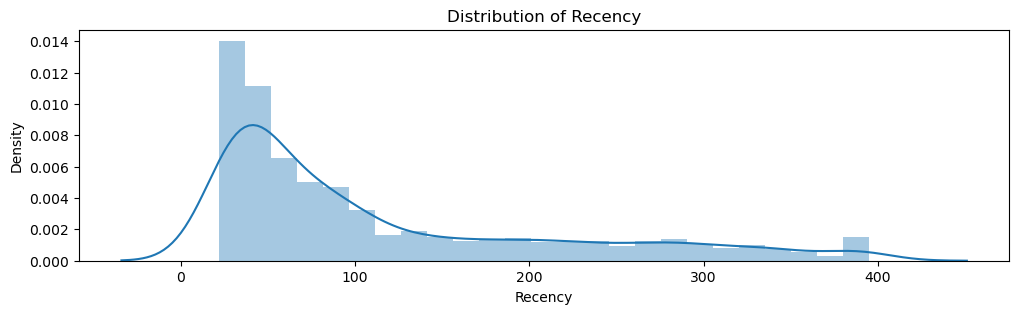

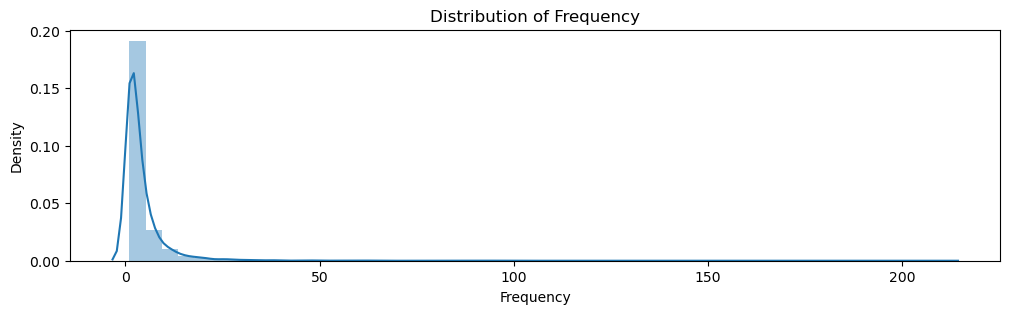

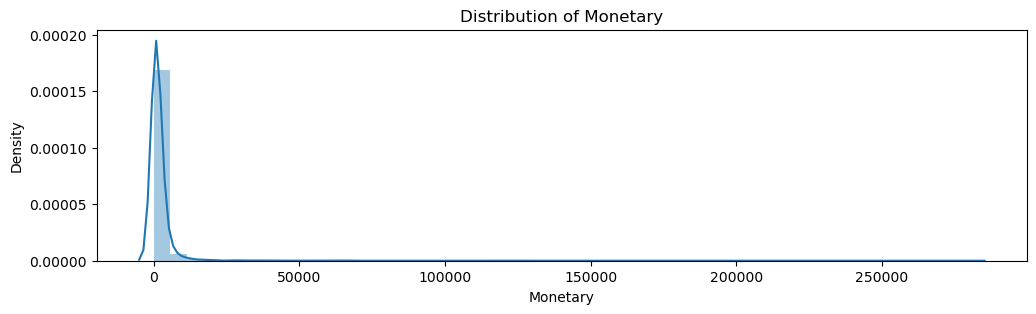

In [14]:
# Assuming you have a DataFrame called 'joined' with columns 'Recency', 'Frequency', 'Monetary'

colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.distplot(customers_RFM[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()


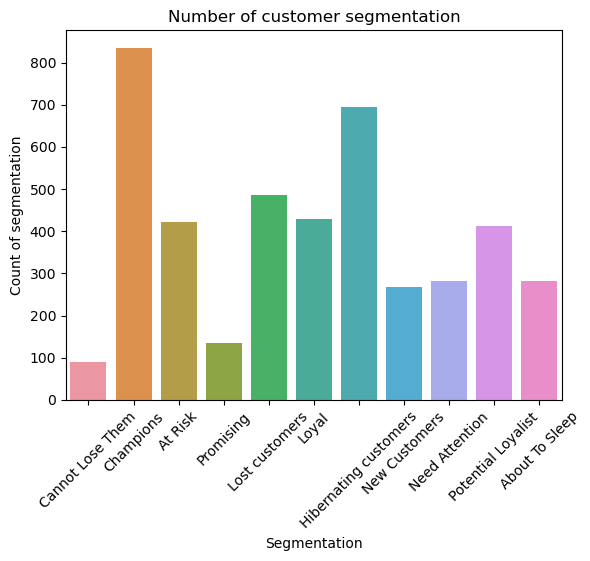

In [15]:
# Seaborn Countplot of customer segmentation
sns.countplot(x=customers_RFM["Segment"])
plt.title('Number of customer segmentation')
plt.xlabel('Segmentation')
plt.ylabel('Count of segmentation')
plt.xticks(rotation=45)
plt.show()

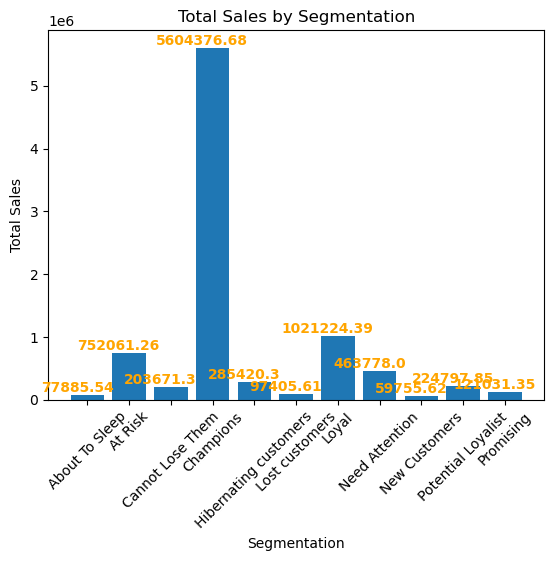

In [16]:
#Bar plot: Total Sales by Segmentation
Sales_seg=customers_RFM.groupby("Segment").agg(sum_sales=("Monetary", "sum")).reset_index()
plt.bar(Sales_seg["Segment"],Sales_seg["sum_sales"])
for i, v in enumerate(round(Sales_seg["sum_sales"],2)):
    plt.text(i-.25, v+0.5, str(v), color='orange', fontweight='bold', ha='center', va='bottom')
plt.title('Total Sales by Segmentation')
plt.xlabel('Segmentation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [17]:
grp = customers_RFM.groupby('Segment').agg({'CustomerID': 'count',
                                     'Monetary': 'sum',
                                     'Recency': 'mean'}).reset_index()
grp.columns = ['Segment', 'Cust_count', 'Total_monetary', 'Avg_recency']
grp.sort_values(by='Cust_count', ascending=False, inplace=True)
grp

,Segment,Cust_count,Total_monetary,Avg_recency
3,Champions,835,5604376.680,32.816766
4,Hibernating customers,695,285420.302,170.817266
5,Lost customers,486,97405.610,297.557613
6,Loyal,428,1021224.390,58.070093
1,At Risk,423,752061.261,165.595745
9,Potential Loyalist,413,224797.850,48.106538
0,About To Sleep,283,77885.540,108.325088
7,Need Attention,281,463778.001,55.245552
8,New Customers,268,59755.620,49.839552
10,Promising,136,121031.350,46.904412


In [18]:
grp['Count_share'] = grp['Cust_count'] / grp['Cust_count'].sum()
grp['Monetary_share'] = grp['Total_monetary'] / grp['Total_monetary'].sum()
grp

,Segment,Cust_count,Total_monetary,Avg_recency,Count_share,Monetary_share
3,Champions,835,5604376.680,32.816766,0.192441,0.628899
4,Hibernating customers,695,285420.302,170.817266,0.160175,0.032029
5,Lost customers,486,97405.610,297.557613,0.112007,0.010930
6,Loyal,428,1021224.390,58.070093,0.098640,0.114597
1,At Risk,423,752061.261,165.595745,0.097488,0.084393
9,Potential Loyalist,413,224797.850,48.106538,0.095183,0.025226
0,About To Sleep,283,77885.540,108.325088,0.065222,0.008740
7,Need Attention,281,463778.001,55.245552,0.064761,0.052043
8,New Customers,268,59755.620,49.839552,0.061765,0.006706
10,Promising,136,121031.350,46.904412,0.031344,0.013582


### Definition and recommended action for each customer segment:

| Segment | Characteristics | Recommendation |
| :-: | :-: | :-: |
| Champions | Bought recently, buy often and spend the most! | Reward them. Can be early adopters for new products. Will promote your brand. |
| Loyal | Spend good money with us often. Responsive to promotions. | Upsell higher value products. Ask for reviews. Engage them. |
| Potential Loyalist | Recent customers, but spent a good amount and bought more than once. | Offer membership / loyalty program, recommend other products. |
| New customers | Bought most recently, but not often. | Provide on-boarding support, give them early success, start building relationship. |
| Promising | Recent shoppers, but haven’t spent much. | Create brand awareness, offer free trials |
| Need attention | Above average recency, frequency and monetary values. May not have bought very recently though. | Make limited time offers, Recommend based on past purchases. Reactivate them. |
| About to sleep | Below average recency, frequency and monetary values. Will lose them if not reactivated. | Share valuable resources, recommend popular products / renewals at discount, reconnect with them. |
| At risk | Spent big money and purchased often. But long time ago. Need to bring them back! | Send personalized emails to reconnect, offer renewals, provide helpful resources. |
| Cannot lose them | Made biggest purchases, and often. But haven’t returned for a long time. | Win them back via renewals or newer products, don’t lose them to competition, talk to them. |
| Hibernating customers | Last purchase was long back, low spenders and low number of orders. | Offer other relevant products and special discounts. Recreate brand value. |
| Lost customers | Lowest recency, frequency and monetary scores. | Revive interest with reach out campaign, ignore otherwise. |

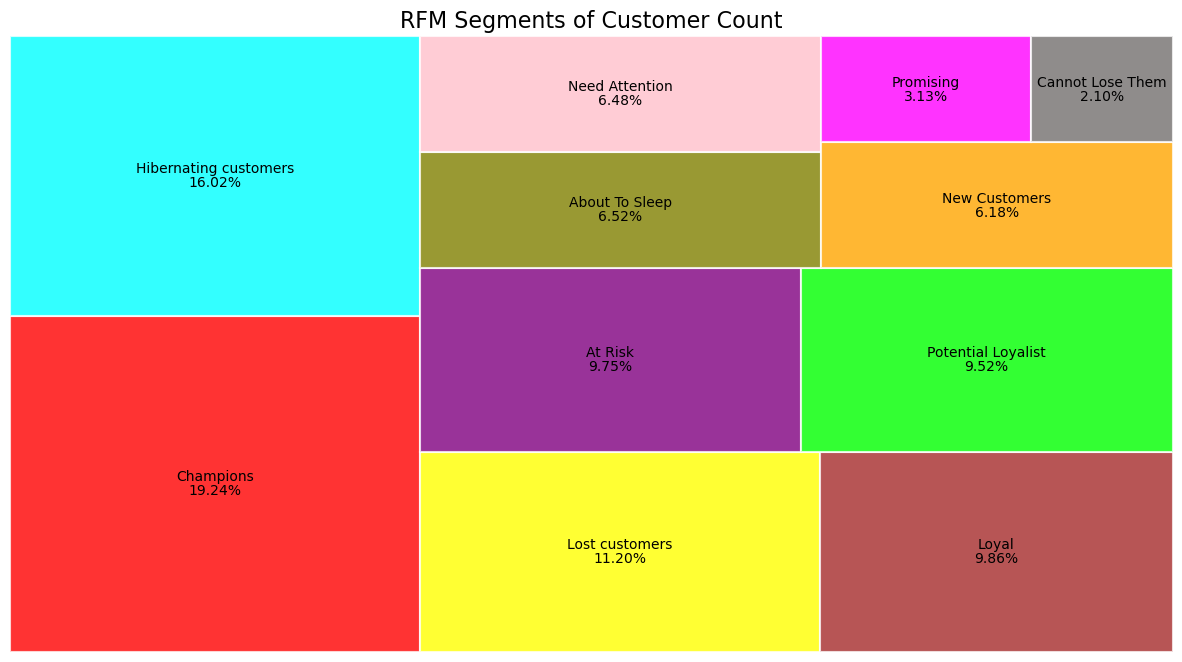

In [19]:
# Build a treemap of customer segmentation
colors = ['#FF0000','#00FFFF','#FFFF00','#A52A2A','#800080','#00FF00','#808000','#FFC0CB','#FFA500','#FF00FF','#736F6E']

fig, ax = plt.subplots(1, figsize = (15,8))

squarify.plot(sizes=grp['Cust_count'], 
              label=grp['Segment'],
              value=[f'{x*100:.2f}%' for x in grp['Count_share']],
              alpha=.8,
              color=colors,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white")
             )
plt.title('RFM Segments of Customer Count', fontsize=16)
plt.axis('off')
plt.show()

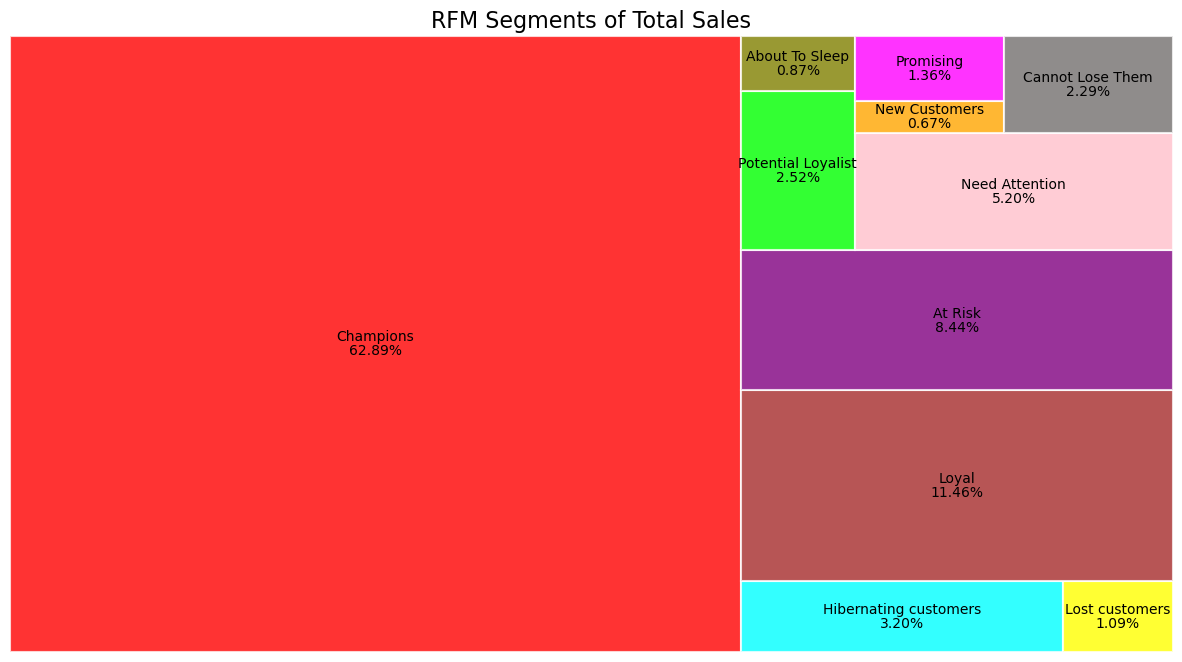

In [20]:
# Build a treemap of sales by customer segmentation
colors = ['#FF0000','#00FFFF','#FFFF00','#A52A2A','#800080','#00FF00','#808000','#FFC0CB','#FFA500','#FF00FF','#736F6E']

fig, ax = plt.subplots(1, figsize = (15,8))

squarify.plot(sizes=grp['Monetary_share'], 
              label=grp['Segment'],
              value=[f'{x*100:.2f}%' for x in grp['Monetary_share']],
              alpha=.8,
              color=colors,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white")
             )
plt.title('RFM Segments of Total Sales', fontsize=16)
plt.axis('off')
plt.show()